In [1]:
import re
import random
from collections import OrderedDict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import numpy as np

import sklearn

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from fancyimpute import MICE

import scipy


/Users/jonathanpoler/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jonathanpoler/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using Theano backend.


/Users/jonathanpoler/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
train = pd.read_csv('~/personal/ai/projects/titanic/train.csv')
test = pd.read_csv('~/personal/ai/projects/titanic/test.csv')

### Ideas for exploration

1. Are the classes balanced? In other words, are the number of survivals approximately proportionate to the number of deaths in the training data?
2. Can I see a 3D vizualization of the data?
3. What are the main sources of variation in the data?
4. Am I dropping features that are actually relevant?

#### Are the classes balanced?

From below it appears that 61.6% of the data are deaths. I'm not sure if that counts as being imbalanced, but it is probably worth looking into different cost functions. Ng's course mentioned F1 score, though sklearn has a huge number of metrics to use.

In [3]:
counts = train['Survived'].value_counts()
counts[0]/ float(counts[0] + counts[1])

0.61616161616161613

#### Can I visualize the data in 3D?



## Feature engineering

I'll be joining train and test for this part

In [4]:
train.info()
print('-'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [5]:
full = train.append(test, ignore_index=True)

In [6]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### Drop Cabin, Name, PassengerId, and Ticket

In [7]:
title_regex = re.compile('''\, (\w+)\.''')
title_regex.findall('Braund, Mr. Owen Harris')

['Mr']

In [8]:
def get_title(s):
	res = title_regex.findall(s)
	if len(res) > 0:
		return res[0]
	return 'no_title'

In [9]:
full['Title'] = full['Name'].apply(lambda s: get_title(s))

In [10]:
full[['Title', 'Survived']].groupby('Title').mean()

          Survived
Title             
Capt      0.000000
Col       0.500000
Don       0.000000
Dona           NaN
Dr        0.428571
Jonkheer  0.000000
Lady      1.000000
Major     0.500000
Master    0.575000
Miss      0.697802
Mlle      1.000000
Mme       1.000000
Mr        0.156673
Mrs       0.792000
Ms        1.000000
Rev       0.000000
Sir       1.000000
no_title  1.000000

In [11]:
full.loc[full['Title'] == 'Dona', 'Title'] = 'Mrs'
full.loc[full['Title'] == 'Mme', 'Title'] = 'Mrs'
full.loc[full['Title'] == 'Mlle', 'Title'] = 'Ms'
full.loc[full['Title'] == 'Miss', 'Title'] = 'Ms'

In [12]:
full.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1, inplace=True)

In [13]:
mlb = preprocessing.MultiLabelBinarizer()
binary_features = mlb.fit_transform(full[['Embarked', 'Sex', 'Title']].as_matrix())
binary_features
full = full.drop(['Embarked', 'Sex', 'Title'], axis=1)
full = full.join(pd.DataFrame(binary_features[:, 1:], columns=mlb.classes_[1:]))

In [14]:
full = full.apply(lambda x: x.apply(lambda y: float(y)))

In [15]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 25 columns):
Age         1046 non-null float64
Fare        1308 non-null float64
Parch       1309 non-null float64
Pclass      1309 non-null float64
SibSp       1309 non-null float64
Survived    891 non-null float64
C           1309 non-null float64
Capt        1309 non-null float64
Col         1309 non-null float64
Don         1309 non-null float64
Dr          1309 non-null float64
Jonkheer    1309 non-null float64
Lady        1309 non-null float64
Major       1309 non-null float64
Master      1309 non-null float64
Mr          1309 non-null float64
Mrs         1309 non-null float64
Ms          1309 non-null float64
Q           1309 non-null float64
Rev         1309 non-null float64
S           1309 non-null float64
Sir         1309 non-null float64
female      1309 non-null float64
male        1309 non-null float64
no_title    1309 non-null float64
dtypes: float64(25)
memory usage: 255.7 KB


In [16]:
full_imp =  MICE().complete(full.drop('Survived', axis=1).as_matrix())
full_complete = pd.DataFrame(full_imp, index=full.index, columns=full.drop('Survived', axis=1).columns)
full_complete.describe()

               Age         Fare        Parch       Pclass        SibSp  \
count  1309.000000  1309.000000  1309.000000  1309.000000  1309.000000   
mean     29.705265    33.295807     0.385027     2.294882     0.498854   
std      12.924077    51.738880     0.865560     0.837836     1.041658   
min       0.170000     0.000000     0.000000     1.000000     0.000000   
25%      22.000000     7.895800     0.000000     2.000000     0.000000   
50%      28.496410    14.454200     0.000000     3.000000     0.000000   
75%      35.000000    31.275000     0.000000     3.000000     1.000000   
max      80.000000   512.329200     9.000000     3.000000     8.000000   

                 C         Capt          Col          Don           Dr  \
count  1309.000000  1309.000000  1309.000000  1309.000000  1309.000000   
mean      0.206264     0.000764     0.003056     0.000764     0.006112   
std       0.404777     0.027639     0.055216     0.027639     0.077967   
min       0.000000     0.000000     0

[MICE] Starting imputation round 87/110, elapsed time 0.154
[MICE] Starting imputation round 88/110, elapsed time 0.155
[MICE] Starting imputation round 89/110, elapsed time 0.156
[MICE] Starting imputation round 90/110, elapsed time 0.157
[MICE] Starting imputation round 91/110, elapsed time 0.158
[MICE] Starting imputation round 92/110, elapsed time 0.159
[MICE] Starting imputation round 93/110, elapsed time 0.160
[MICE] Starting imputation round 94/110, elapsed time 0.161
[MICE] Starting imputation round 95/110, elapsed time 0.162
[MICE] Starting imputation round 96/110, elapsed time 0.162
[MICE] Starting imputation round 97/110, elapsed time 0.163
[MICE] Starting imputation round 98/110, elapsed time 0.164
[MICE] Starting imputation round 99/110, elapsed time 0.165
[MICE] Starting imputation round 100/110, elapsed time 0.166
[MICE] Starting imputation round 101/110, elapsed time 0.167
[MICE] Starting imputation round 102/110, elapsed time 0.167
[MICE] Starting imputation round 103/

[MICE] Starting imputation round 68/110, elapsed time 0.134
[MICE] Starting imputation round 69/110, elapsed time 0.135
[MICE] Starting imputation round 70/110, elapsed time 0.136
[MICE] Starting imputation round 71/110, elapsed time 0.137
[MICE] Starting imputation round 72/110, elapsed time 0.138
[MICE] Starting imputation round 73/110, elapsed time 0.139
[MICE] Starting imputation round 74/110, elapsed time 0.140
[MICE] Starting imputation round 75/110, elapsed time 0.141
[MICE] Starting imputation round 76/110, elapsed time 0.142
[MICE] Starting imputation round 77/110, elapsed time 0.143
[MICE] Starting imputation round 78/110, elapsed time 0.144
[MICE] Starting imputation round 79/110, elapsed time 0.145
[MICE] Starting imputation round 80/110, elapsed time 0.146
[MICE] Starting imputation round 81/110, elapsed time 0.147
[MICE] Starting imputation round 82/110, elapsed time 0.148
[MICE] Starting imputation round 83/110, elapsed time 0.149
[MICE] Starting imputation round 84/110,

[MICE] Starting imputation round 57/110, elapsed time 0.124
[MICE] Starting imputation round 58/110, elapsed time 0.125
[MICE] Starting imputation round 59/110, elapsed time 0.126
[MICE] Starting imputation round 60/110, elapsed time 0.127
[MICE] Starting imputation round 61/110, elapsed time 0.128
[MICE] Starting imputation round 62/110, elapsed time 0.129
[MICE] Starting imputation round 63/110, elapsed time 0.129
[MICE] Starting imputation round 64/110, elapsed time 0.130
[MICE] Starting imputation round 65/110, elapsed time 0.131
[MICE] Starting imputation round 66/110, elapsed time 0.132
[MICE] Starting imputation round 67/110, elapsed time 0.133


[MICE] Starting imputation round 43/110, elapsed time 0.111
[MICE] Starting imputation round 44/110, elapsed time 0.112
[MICE] Starting imputation round 45/110, elapsed time 0.113
[MICE] Starting imputation round 46/110, elapsed time 0.114
[MICE] Starting imputation round 47/110, elapsed time 0.115
[MICE] Starting imputation round 48/110, elapsed time 0.115
[MICE] Starting imputation round 49/110, elapsed time 0.116
[MICE] Starting imputation round 50/110, elapsed time 0.117
[MICE] Starting imputation round 51/110, elapsed time 0.118
[MICE] Starting imputation round 52/110, elapsed time 0.119
[MICE] Starting imputation round 53/110, elapsed time 0.120
[MICE] Starting imputation round 54/110, elapsed time 0.120
[MICE] Starting imputation round 55/110, elapsed time 0.121
[MICE] Starting imputation round 56/110, elapsed time 0.122


[MICE] Starting imputation round 20/110, elapsed time 0.089
[MICE] Starting imputation round 21/110, elapsed time 0.090
[MICE] Starting imputation round 22/110, elapsed time 0.091
[MICE] Starting imputation round 23/110, elapsed time 0.092
[MICE] Starting imputation round 24/110, elapsed time 0.093
[MICE] Starting imputation round 25/110, elapsed time 0.094
[MICE] Starting imputation round 26/110, elapsed time 0.095
[MICE] Starting imputation round 27/110, elapsed time 0.096
[MICE] Starting imputation round 28/110, elapsed time 0.097
[MICE] Starting imputation round 29/110, elapsed time 0.098
[MICE] Starting imputation round 30/110, elapsed time 0.099
[MICE] Starting imputation round 31/110, elapsed time 0.100
[MICE] Starting imputation round 32/110, elapsed time 0.100
[MICE] Starting imputation round 33/110, elapsed time 0.101
[MICE] Starting imputation round 34/110, elapsed time 0.102
[MICE] Starting imputation round 35/110, elapsed time 0.103
[MICE] Starting imputation round 36/110,

[MICE] Starting imputation round 12/110, elapsed time 0.081
[MICE] Starting imputation round 13/110, elapsed time 0.082
[MICE] Starting imputation round 14/110, elapsed time 0.083
[MICE] Starting imputation round 15/110, elapsed time 0.084
[MICE] Starting imputation round 16/110, elapsed time 0.085
[MICE] Starting imputation round 17/110, elapsed time 0.086
[MICE] Starting imputation round 18/110, elapsed time 0.086
[MICE] Starting imputation round 19/110, elapsed time 0.087


[MICE] Starting imputation round 2/110, elapsed time 0.070
[MICE] Starting imputation round 3/110, elapsed time 0.072
[MICE] Starting imputation round 4/110, elapsed time 0.073
[MICE] Starting imputation round 5/110, elapsed time 0.074
[MICE] Starting imputation round 6/110, elapsed time 0.075
[MICE] Starting imputation round 7/110, elapsed time 0.076
[MICE] Starting imputation round 8/110, elapsed time 0.077
[MICE] Starting imputation round 9/110, elapsed time 0.078
[MICE] Starting imputation round 10/110, elapsed time 0.079
[MICE] Starting imputation round 11/110, elapsed time 0.079


[MICE] Completing matrix with shape (1309, 24)
[MICE] Starting imputation round 1/110, elapsed time 0.001


In [17]:
X_train = full_complete[:891]
X_test = full_complete[891:]
y_train = full['Survived'][:891]

In [18]:


clf = make_pipeline(preprocessing.Imputer(strategy='median', missing_values='NaN'),
					preprocessing.StandardScaler(),
					PCA(n_components=3))


X_r = clf.fit_transform(X_train)


In [19]:
sinkers = X_r[np.ix_(y_train == 0, [0, 1, 2])]
floaters = X_r[np.ix_(y_train == 1, [0, 1, 2])]

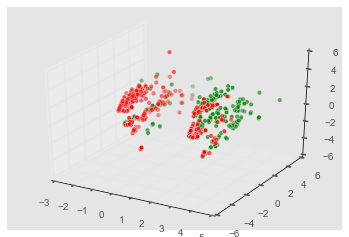

In [20]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(sinkers[:, 0], sinkers[:, 1], sinkers[:, 2], c='r')
threedee.scatter(floaters[:, 0], floaters[:, 1], floaters[:, 2], c='g')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

# Methodology

One of the things I am trying to figure out at this early stage is to develop at least in very general terms an algorithm of steps that can be used to approach a new dataset. I'll try to enumerate what I have come up with so far:

1. Explore data manually / graphically
2. Clean data
3. Scale data
4. Fit a model to the data
	- cross-validation
	- grid search
	- try a number of different estimators
	5. Evaluate the generality of that model

### Feature Imputation

From what I've read, it is only acceptable to perform impution on the training data. This confuses me, because I was under the impression that predictors would need all values to be present. Anyway, random forests can handle missing values, so I'm just going to leave this out for now and come back and do impution only if necessary.

### Hyperparameter Grid Search With Pipeline

The choice of parameters can be justified as follows.

#### Impution

All of the missing features are NaN. The choice between median and mean is more interesting. I have read in several places that a good rule of thumb is to impute numerical features with the median of that feature, and categorical features with the mode of that feature.

#### Robust Scaler

I chose to use Robust scaler because the fare features are pretty skewed. If they weren't skewed I would have used NormalScaler.

#### SVC

I chose to use [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) because it is one of the algorithms covered in Andrew Ng's Coursera machine learning course. That gave me a bit more confidence in choosing parameters. I'll also return to exprementing with ensemble methods if this doesn't show promise. [This Resource](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html) suggested using a logarithmic grid for C and gamma between $10^{-3} and 10^{3}$. I'm also trying both a linear kernel and the rbf (radial basis function) kernel. C is a regularization paremeter. Gamma can be though of as restricting the size of the radius of influence of each individual training example.

In [21]:
# params = [
# 	dict(imputer__strategy=['median', 'most_frequent'],
# 		 randomforestclassifier__n_estimators=[i for i in range(20, 180, 10)],
# 		 randomforestclassifier__max_features=['auto', 'sqrt', 'log2'])
# ]
# params = [
# 	dict(randomforestclassifier__n_estimators=[i for i in range(20, 180, 10)],
# 		 randomforestclassifier__max_features=['auto', 'sqrt', 'log2'])
# ]

# clf = make_pipeline(
# #	preprocessing.Imputer(missing_values='NaN'),
# 	RandomForestClassifier(),
# )

# grid_search = GridSearchCV(clf, params, verbose=1, cv=5, n_jobs=4)

# grid_search.fit(X_train.fillna(-1), y_train)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.lda import LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

X_ready = preprocessing.RobustScaler().fit_transform(X_train)

random_seed = 7
num_instances = len(X_ready)
n_folds = 10

classifiers = [
	KNeighborsClassifier(),
	DecisionTreeClassifier(),
	RandomForestClassifier(),
	AdaBoostClassifier(),
	SVC(),
	GaussianProcessClassifier(),
	GaussianNB(),
	MLPClassifier(),
	LDA(),
]

results, names = [], []

for clf in classifiers:
	kfold = sklearn.cross_validation.KFold(n=num_instances, n_folds=n_folds, random_state=random_seed)
	cv_results = sklearn.cross_validation.cross_val_score(clf, X_ready, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(clf.__class__.__name__)
	print('{}: {} ({})'.format(clf.__class__.__name__, cv_results.mean(), cv_results.std()))


/Users/jonathanpoler/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


MLPClassifier: 0.817066167291 (0.0446433306857)
LinearDiscriminantAnalysis: 0.827178526841 (0.0392177755396)


GaussianProcessClassifier: 0.817078651685 (0.0332280456436)
GaussianNB: 0.674382022472 (0.148741129978)


SVC: 0.831660424469 (0.0375477457925)


AdaBoostClassifier: 0.81822721598 (0.0251131904333)


RandomForestClassifier: 0.810411985019 (0.0493842061274)


/Users/jonathanpoler/anaconda2/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


KNeighborsClassifier: 0.81936329588 (0.0396714084139)
DecisionTreeClassifier: 0.773433208489 (0.0491465691865)


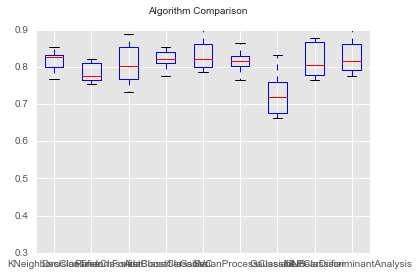

In [23]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')	
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.rcParams['figure.figsize'] = [20, 8]
plt.show()


It looks like K-nearest-neighbors is doing well due to its low variance. Let's try and get a good result out of that.

In [24]:
# params = [
# 	dict(kneighborsclassifier__n_neighbors=np.linspace(5, 50, 10),
# 		 kneighborsclassifier__weights=['uniform', 'distance'],
# 		 kneighborsclassifier__p=[1,2,3,4],
# 		 kneighborsclassifier__leaf_size=np.linspace(10, 100, 10),
# 	)
# ]

# # 
# clf = make_pipeline(
# 	preprocessing.RobustScaler(),
# 	KNeighborsClassifier(),
# )

# grid_search = GridSearchCV(clf, params, verbose=1, cv=10, n_jobs=4)

# grid_search.fit(X_train, y_train)


In [62]:
params = dict(pca__n_components=range(1, len(X_train.columns), 2),
		 svc__C=scipy.stats.expon(scale=100),
		 svc__gamma=scipy.stats.expon(scale=.1),
		 svc__kernel=['rbf', 'sigmoid'],
		 svc__class_weight=['balanced', None],
		 svc__decision_function_shape=['ovo', 'ovr'],
)


# 
clf = make_pipeline(
	preprocessing.StandardScaler(),
	PCA(),
	SVC(cache_size=1024)
)

grid_search = RandomizedSearchCV(clf, params, verbose=1, cv=10, n_jobs=4, n_iter=300)

grid_search.fit(X_train, y_train)


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=1024, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
          fit_params={}, iid=True, n_iter=300, n_jobs=4,
          param_distributions={'svc__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x122b98950>, 'svc__class_weight': ['balanced', None], 'svc__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x122b98510>, 'svc__decision_function_shape': ['ovo', 'ovr'], 'pca__n_components': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], 'svc__kernel': ['rbf', 'sigmoid']},
          pre_dispatch='2*n_job

[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:   59.6s finished


[Parallel(n_jobs=4)]: Done 1744 tasks      | elapsed:   30.0s


[Parallel(n_jobs=4)]: Done 744 tasks      | elapsed:   12.8s


[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.9s


Fitting 10 folds for each of 300 candidates, totalling 3000 fits


In [74]:
grid_search.best_score_

0.8316498316498316

In [75]:
grid_search.best_params_

{'pca__n_components': 17,
 'svc__C': 96.28045343586771,
 'svc__class_weight': None,
 'svc__decision_function_shape': 'ovr',
 'svc__gamma': 0.026012408919146662,
 'svc__kernel': 'rbf'}

In [65]:
from sklearn.externals import joblib

joblib.dump(grid_search, '/tmp/randomsearch-scv-5.pkl')


['/tmp/randomsearch-scv-5.pkl']

In [73]:
grid_search = joblib.load('/tmp/randomsearch-scv-1.pkl')

In [28]:
grid_search.get_params()

{'cv': 10,
 'error_score': 'raise',
 'estimator': Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=1024, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False))]),
 'estimator__pca': PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'estimator__pca__copy': True,
 'estimator__pca__iterated_power': 'auto',
 'estimator__pca__n_components': None,
 'estimator__pca__random_state': None,
 'estimator__pca__svd_solver': 'auto',
 'estimator__pca__tol': 0.0,
 'estimator__pca__whiten': False,
 'estimator__standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 '

In [29]:
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 24 columns):
Age         418 non-null float64
Fare        418 non-null float64
Parch       418 non-null float64
Pclass      418 non-null float64
SibSp       418 non-null float64
C           418 non-null float64
Capt        418 non-null float64
Col         418 non-null float64
Don         418 non-null float64
Dr          418 non-null float64
Jonkheer    418 non-null float64
Lady        418 non-null float64
Major       418 non-null float64
Master      418 non-null float64
Mr          418 non-null float64
Mrs         418 non-null float64
Ms          418 non-null float64
Q           418 non-null float64
Rev         418 non-null float64
S           418 non-null float64
Sir         418 non-null float64
female      418 non-null float64
male        418 non-null float64
no_title    418 non-null float64
dtypes: float64(24)
memory usage: 78.4 KB
None


In [30]:
print(X_test.isnull().sum())

Age         0
Fare        0
Parch       0
Pclass      0
SibSp       0
C           0
Capt        0
Col         0
Don         0
Dr          0
Jonkheer    0
Lady        0
Major       0
Master      0
Mr          0
Mrs         0
Ms          0
Q           0
Rev         0
S           0
Sir         0
female      0
male        0
no_title    0
dtype: int64


In [67]:
predictions = grid_search.predict(X_test)

In [68]:
predictions

array([ 0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
        0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
        1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0

In [71]:
output = test.join(pd.DataFrame(predictions.astype(int), columns=['Survived']))

In [76]:
output[['PassengerId', 'Survived']].to_csv('~/personal/ai/projects/titanic/svc-pca-predictions-4.csv', sep=',', index=False)